# AAI-521 Final Project – Group 3  
## 04 – Vehicle Counting and LMV vs HMV Analysis

**Goal:**  
Use the trained vehicle classification CNN and the UA-DETRAC annotations to:

- Count vehicles per frame in a selected sequence
- Group vehicle predictions into:
  - LMV (Light Motor Vehicle) – e.g., cars, vans
  - HMV (Heavy Motor Vehicle) – e.g., buses, trucks
- Visualize LMV vs HMV counts over time
- Produce basic traffic analytics (peak frames, LMV/HMV ratio)

This notebook builds on:

- Notebook 02: preprocessed cropped dataset (`cropped_vehicle_dataset.npz`)
- Notebook 03: trained CNN model (`models/vehicle_classifier.pth`)

#### Imports & Configuration

In [1]:
import sys
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.style.use("seaborn-v0_8")

# Paths (adapt if your structure differs)
PROJECT_ROOT = Path().resolve().parent
DATA_ROOT = PROJECT_ROOT / "data"
IMAGES_ROOT = DATA_ROOT / "DETRAC-Images"
TRAIN_ANN_ROOT = DATA_ROOT / "DETRAC-Train-Annotations"
OUTPUT_ROOT = PROJECT_ROOT / "outputs"
SRC_DIR = PROJECT_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_detrac import load_detrac_annotations, VehicleClassifier, predict_vehicle_class

CROPPED_DATA_PATH = DATA_ROOT / "cropped_vehicle_dataset.npz"
MODELS_DIR = PROJECT_ROOT / "models"
MODEL_PATH = MODELS_DIR / "vehicle_classifier.pth"

print("Project root:", PROJECT_ROOT)
print("Images root:", IMAGES_ROOT)
print("Train annotations root:", TRAIN_ANN_ROOT)
print("Cropped dataset path:", CROPPED_DATA_PATH)
print("Model path:", MODEL_PATH)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Project root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3
Images root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Images
Train annotations root: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/DETRAC-Train-Annotations
Cropped dataset path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/data/cropped_vehicle_dataset.npz
Model path: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/models/vehicle_classifier.pth
Using device: cpu


#### Load Cropped Dataset Metadata

In [2]:
data = np.load(CROPPED_DATA_PATH, allow_pickle=True)
images = data["images"]              # (N, H, W, 3)
labels = data["labels"]              # (N,)
class_to_idx = data["class_to_idx"].item()
metadata = data["metadata"]

idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Images shape:", images.shape)
print("Classes:", idx_to_class)

crop_h, crop_w = images.shape[1], images.shape[2]
TARGET_SIZE = (crop_w, crop_h)  # (width, height) for cv2.resize
print("CNN input size (W,H):", TARGET_SIZE)

Images shape: (598281, 64, 64, 3)
Classes: {0: 'car', 1: 'van', 2: 'others', 3: 'bus'}
CNN input size (W,H): (64, 64)


#### Rebuild CNN Architecture & Load Weights

In [3]:
num_classes = len(class_to_idx)
model = VehicleClassifier(num_classes=num_classes).to(DEVICE)

state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

print("Loaded model from:", MODEL_PATH)

Loaded model from: /Users/matthashemi/Documents/Personal/University/MS-AAI-Courses/07-AAI-521/aai-521-final-project-g3/models/vehicle_classifier.pth


## 1. LMV vs HMV Mapping

We group the CNN's fine-grained classes into:

- **LMV (Light Motor Vehicle)**: car, van, others (if present)
- **HMV (Heavy Motor Vehicle)**: bus, truck

Any unexpected or unknown class will be labeled as `"Unknown"`.

#### LMV/HMV Mapping

In [4]:
# Define mapping from DETRAC class → LMV/HMV
# Adjust if your dataset uses slightly different names.
fine_classes = list(idx_to_class.values())
print("Fine-grained classes from CNN:", fine_classes)

LMV_CLASSES = {"car", "van", "others", "motor"}   # tweak as needed
HMV_CLASSES = {"bus", "truck"}

def map_to_lmv_hmv(fine_class: str) -> str:
    c = fine_class.lower()
    if c in LMV_CLASSES:
        return "LMV"
    if c in HMV_CLASSES:
        return "HMV"
    return "Unknown"

Fine-grained classes from CNN: ['car', 'van', 'others', 'bus']


## 2. Vehicle Counting per Frame (Using CNN Predictions)

We now:

1. Select a DETRAC sequence (e.g., `MVI_20011`).
2. For each frame:
   - Read the original image.
   - Use the XML annotations to get bounding boxes.
   - Crop each bounding box, resize to CNN input size, run the model.
   - Map predicted class to LMV or HMV.
3. Store per-frame counts in a pandas DataFrame.

#### Counting Function

In [5]:
def compute_counts_for_sequence(
    seq_id: str,
    model,
    images_root=IMAGES_ROOT,
    ann_root=TRAIN_ANN_ROOT,
    target_size=TARGET_SIZE,
    device=DEVICE,
    fps=25.0,  # UA-DETRAC uses 25 FPS; adjust if needed
):
    """
    Returns a pandas DataFrame with per-frame counts:
    columns: [frame, time_sec, total_count, LMV_count, HMV_count, Unknown_count]
    """
    seq_images_dir = images_root / seq_id
    xml_path = ann_root / f"{seq_id}.xml"

    assert seq_images_dir.exists(), f"Image folder not found: {seq_images_dir}"
    assert xml_path.exists(), f"XML file not found: {xml_path}"

    annotations = load_detrac_annotations(xml_path)

    # Determine available frames by checking image files
    image_files = sorted(
        f for f in seq_images_dir.iterdir()
        if f.suffix.lower() == ".jpg"
    )
    frame_nums = [
        int(f.stem.replace("img", "")) for f in image_files
    ]

    records = []

    for frame_num in frame_nums:
        img_path = seq_images_dir / f"img{frame_num:05d}.jpg"
        frame_bgr = cv2.imread(str(img_path))
        if frame_bgr is None:
            continue

        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        h_img, w_img = frame_rgb.shape[:2]

        targets = annotations.get(frame_num, [])
        total = 0
        count_lmv = 0
        count_hmv = 0
        count_unknown = 0

        for t in targets:
            x, y, w, h = t["bbox"]

            x1 = max(int(x), 0)
            y1 = max(int(y), 0)
            x2 = min(int(x + w), w_img)
            y2 = min(int(y + h), h_img)

            if x2 <= x1 or y2 <= y1:
                continue

            crop = frame_rgb[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            crop_resized = cv2.resize(crop, target_size)
            pred_label, conf = predict_vehicle_class(crop_resized, model, idx_to_class, device=device)

            group = map_to_lmv_hmv(pred_label)

            total += 1
            if group == "LMV":
                count_lmv += 1
            elif group == "HMV":
                count_hmv += 1
            else:
                count_unknown += 1

        time_sec = frame_num / fps

        records.append({
            "frame": frame_num,
            "time_sec": time_sec,
            "total_count": total,
            "LMV_count": count_lmv,
            "HMV_count": count_hmv,
            "Unknown_count": count_unknown,
        })

    df = pd.DataFrame(records).sort_values("frame").reset_index(drop=True)
    return df

#### Run Counting for a Sequence

In [6]:
SEQ_ID = "MVI_20011"  # change to another sequence as needed

df_counts = compute_counts_for_sequence(SEQ_ID, model)
df_counts.head()

,frame,time_sec,total_count,LMV_count,HMV_count,Unknown_count
0,1,0.04,7,7,0,0
1,2,0.08,7,7,0,0
2,3,0.12,7,7,0,0
3,4,0.16,7,7,0,0
4,5,0.20,7,7,0,0


## 3. Basic Traffic Summary for the Sequence

In [7]:
print(f"Sequence: {SEQ_ID}")
print(f"Number of frames analyzed: {len(df_counts)}")
print()

print("Overall mean counts per frame:")
print(df_counts[["total_count", "LMV_count", "HMV_count", "Unknown_count"]].mean())

print("\nMax counts in a single frame:")
print(df_counts[["total_count", "LMV_count", "HMV_count"]].max())

peak_frame = df_counts.loc[df_counts["total_count"].idxmax(), "frame"]
peak_time = df_counts.loc[df_counts["total_count"].idxmax(), "time_sec"]
print(f"\nPeak traffic frame: {peak_frame} (t = {peak_time:.2f} s)")

Sequence: MVI_20011
Number of frames analyzed: 664

Overall mean counts per frame:
total_count      11.528614
LMV_count        11.385542
HMV_count         0.143072
Unknown_count     0.000000
dtype: float64

Max counts in a single frame:
total_count    16
LMV_count      16
HMV_count       1
dtype: int64

Peak traffic frame: 103 (t = 4.12 s)


## 4. LMV vs HMV Counts Over Time

We plot how the number of LMVs and HMVs evolves over time in the sequence.
This gives a simple view of traffic intensity and composition.

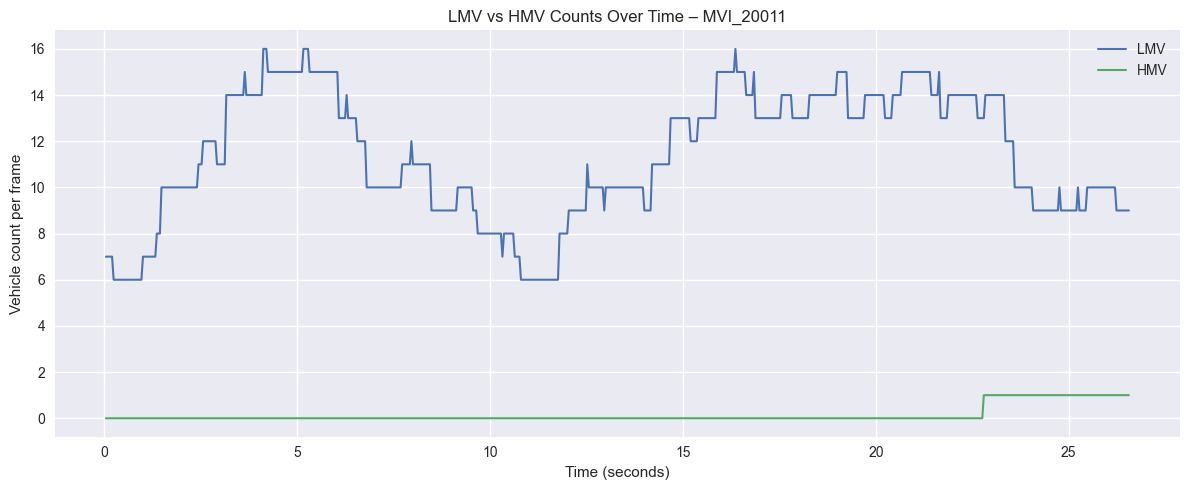

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_counts["time_sec"], df_counts["LMV_count"], label="LMV", linewidth=1.5)
ax.plot(df_counts["time_sec"], df_counts["HMV_count"], label="HMV", linewidth=1.5)

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Vehicle count per frame")
ax.set_title(f"LMV vs HMV Counts Over Time – {SEQ_ID}")
ax.legend()
plt.tight_layout()
plt.show()

## 5. LMV/HMV Ratio Over Time

We compute the ratio `HMV_count / (LMV_count + HMV_count)` as a proxy for
the proportion of heavy vehicles in the traffic flow.

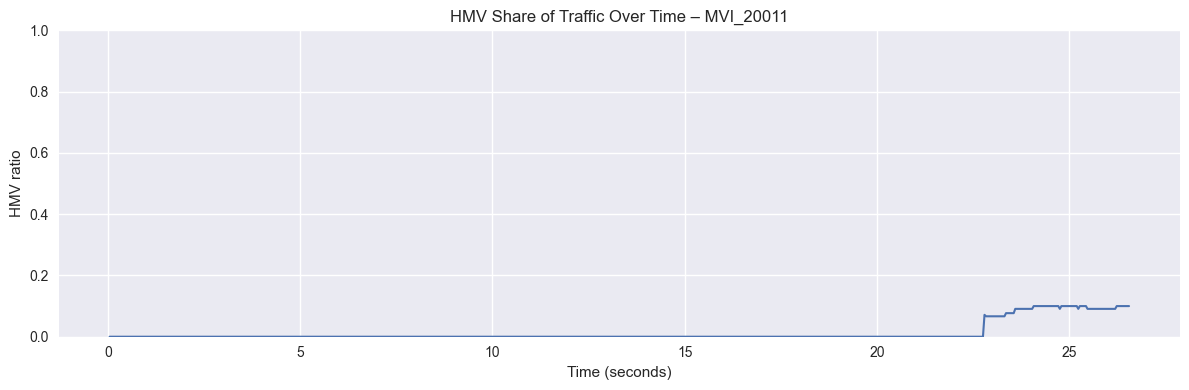

In [9]:
df_counts["denom"] = df_counts["LMV_count"] + df_counts["HMV_count"]
df_counts["HMV_ratio"] = df_counts["HMV_count"] / df_counts["denom"].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_counts["time_sec"], df_counts["HMV_ratio"], linewidth=1.5)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("HMV ratio")
ax.set_ylim(0, 1)
ax.set_title(f"HMV Share of Traffic Over Time – {SEQ_ID}")
plt.tight_layout()
plt.show()

## 6. Distribution of Vehicle Counts per Frame

We visualize how often different traffic levels occur in this sequence.

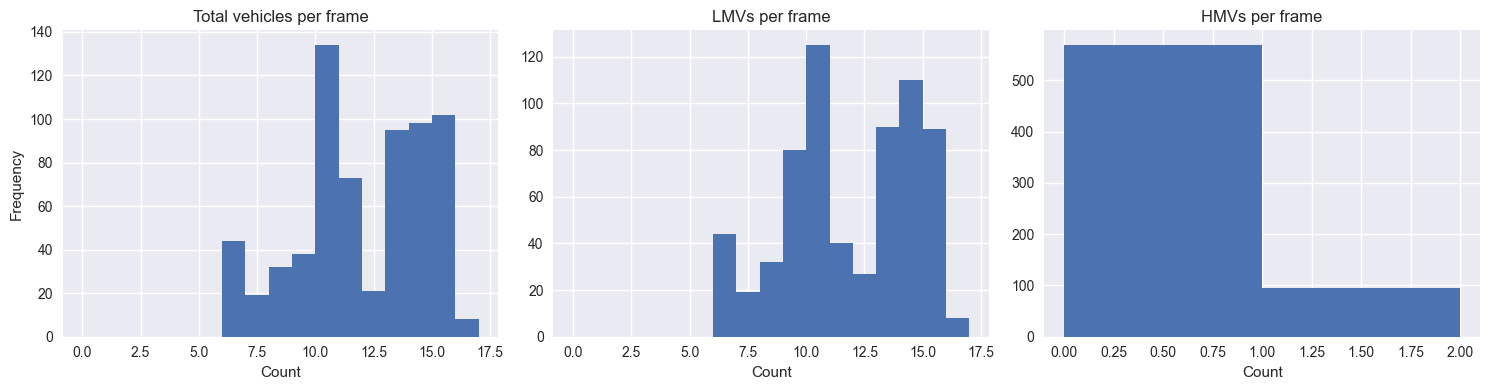

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df_counts["total_count"], bins=range(0, df_counts["total_count"].max() + 2))
axes[0].set_title("Total vehicles per frame")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Frequency")

axes[1].hist(df_counts["LMV_count"], bins=range(0, df_counts["LMV_count"].max() + 2))
axes[1].set_title("LMVs per frame")
axes[1].set_xlabel("Count")

axes[2].hist(df_counts["HMV_count"], bins=range(0, df_counts["HMV_count"].max() + 2))
axes[2].set_title("HMVs per frame")
axes[2].set_xlabel("Count")

plt.tight_layout()
plt.show()

## 7. Traffic Prediction Using Time-Series Regression (Optional)

We now treat the per-frame vehicle counts as a **time series** and build a simple
short-term traffic prediction model.

Goal:
- Predict the **next frame's total vehicle count** from the previous `K` frames.

This demonstrates how the outputs of our detection + classification pipeline
can be used for **traffic forecasting** at the sequence level.

#### build lag features

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# We will predict next-frame total_count using previous K frames
K = 5  # history length (you can change this)

df = df_counts.copy().reset_index(drop=True)

# Build lag features: total_count_{t-1}, ..., total_count_{t-K}
for lag in range(1, K + 1):
    df[f"total_lag_{lag}"] = df["total_count"].shift(lag)

# Drop initial rows with NaNs due to shifting
df_model = df.dropna().reset_index(drop=True)

feature_cols = [f"total_lag_{lag}" for lag in range(1, K + 1)]
target_col = "total_count"

X = df_model[feature_cols].values
y = df_model[target_col].values

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (659, 5)
Target shape: (659,)


#### train/test split + model + metrics

In [12]:
# Simple train/test split along time (no shuffling, to respect temporal order)
# Use first 80% of frames for training, last 20% for testing
n = len(df_model)
split_idx = int(0.8 * n)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Use a RandomForestRegressor as a simple non-linear baseline
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.3f}")
print(f"Test R^2: {r2:.3f}")

Train size: 527, Test size: 132
Test MAE: 0.202
Test R^2: 0.947


#### plot actual vs predicted over time

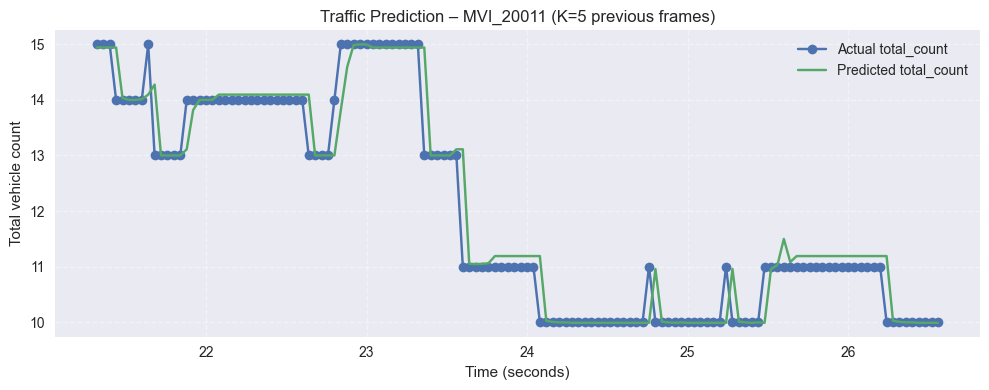

In [13]:
# Time axis for the test segment
time_test = df_model["time_sec"].values[split_idx:]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(time_test, y_test, label="Actual total_count", marker="o")
ax.plot(time_test, y_pred, label="Predicted total_count", marker="x")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Total vehicle count")
ax.set_title(f"Traffic Prediction – {SEQ_ID} (K={K} previous frames)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### Interpretation – Traffic Prediction

- The model learns to approximate how total vehicle count changes from
  frame to frame, using only the previous `K` frames.
- When the **R² score is reasonably high** and **MAE is small**, predictions
  follow the overall trend of the true counts.
- Sudden spikes or drops in traffic are harder to predict, which is a
  common challenge in real-world traffic forecasting.

## 8. Summary and Interpretation

- We used the CNN's **predicted vehicle classes** to count:
  - Total vehicles per frame
  - LMV vs HMV counts
- The **LMV vs HMV time plot** shows how traffic composition changes
  across the selected video segment.
- The **HMV ratio over time** indicates periods where heavy vehicles
  dominate or are rare.
- The **histograms** summarize the overall distribution of traffic load
  in this sequence (e.g., typical counts per frame, peak congestion).
- Using these per-frame counts as a **time series**, we trained a simple
  regression model (Random Forest) to **predict the next frame's total
  vehicle count** based on the previous `K` frames, demonstrating a basic
  short-term traffic forecasting capability.

These figures and insights can be used in the final report to support
statements such as:
- "Most frames contain X–Y vehicles, with occasional peaks up to Z."
- "Traffic is dominated by LMVs, with HMVs accounting for about P% on
  average."
- "Certain time intervals show a higher concentration of heavy vehicles,
  which may relate to freight or bus traffic."
- "A simple time-series model can reasonably track short-term changes
  in traffic volume, capturing overall trends while sometimes
  underestimating sudden spikes in congestion."